# Part 3 - Words that characterize Computational Social Science communities

### 1.1 What does TF stand for?
#### Answer: TF stands for term frequency which measures how often a specific term appears in a set of text document. Higher frequency = higher relevance of word to document's content

### 1.2 What does IDF stand for?
#### Answer: IDF stands for inverse document frequency, reducing weight of common words and increasing weight of 'rarer' words. When a word appears in fewer text documents = more meaningful

### 2.

In [7]:
import pandas as pd
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import json
from sklearn.feature_extraction.text import TfidfVectorizer 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
MAX_WORKERS = 8
API_DELAY = 0.1

authors_df = pd.read_csv('authors.csv')
author_comm = pd.read_csv('author_communities.csv')
abstracts = pd.read_csv('abstracts_with_collocations.csv')

# Preprocess Tokens
abstracts['tokens'] = abstracts['collocation_tokens'].map(
    lambda x: eval(x) if isinstance(x, str) else x,
    na_action='ignore'
)
work_to_tokens = {
    work_id.split('/')[-1]: tokens  # Extract 'W...' from URLs
    for work_id, tokens in zip(abstracts['id'], abstracts['tokens'])
}

# Parallel API Fetching
def fetch_author_works(author_url):
    try:
        response = requests.get(f"{author_url}?per-page=200", timeout=10)
        if response.status_code == 200:
            works = [w['id'].split('/')[-1] for w in response.json().get('results', [])]
            return (author_url.split('/')[-1], works)  # Return (author_id, works)
        return (author_url.split('/')[-1], None)
    except Exception: return (author_url.split('/')[-1], None)

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    results = list(tqdm(
        executor.map(fetch_author_works, authors_df['Works API URL']),
        total=len(authors_df)
    ))

author_to_works = {k: v for k, v in results if v is not None}
failed_authors = [k for k, v in results if v is None]

100%|██████████| 1147/1147 [03:24<00:00,  5.60it/s]


In [5]:
# Community Processing
valid_works = set(abstracts['id'])
community_tokens = {}
community_token_arrays = {} 
community_stats = {}

for comm, group in author_comm.groupby('community'):
    works = [
        work 
        for author in group['author_id'] 
        for work in author_to_works.get(author, [])
        if work in valid_works
    ]
    
    comm_tokens = [
        tok 
        for work in works 
        for tok in work_to_tokens.get(work, [])
    ]
    
    community_tokens[comm] = comm_tokens

# Save
with open('community_tokens.json', 'w') as f:
    json.dump(community_tokens, f)

for community, group in tqdm(author_comm.groupby('community'), desc="Processing communities"):
    token_array = []  # store ALL tokens as a list of strings
    stats = {
        'authors_processed': 0,
        'total_works': 0,
        'works_with_tokens': 0
    }
    
    for author_id in group['author_id']:
        author_key = f"works?filter=author.id:{author_id.split('/')[-1]}"
        
        if author_key not in author_to_works: continue
            
        stats['authors_processed'] += 1
        
        for work_id in author_to_works[author_key]:
            stats['total_works'] += 1
            if work_id in work_to_tokens:
                tokens = work_to_tokens[work_id]
                if tokens:  # Only add non-empty
                    token_array.extend(tokens)
                    stats['works_with_tokens'] += 1
    
    community_token_arrays[community] = token_array
    community_stats[community] = stats

# Save
with open('community_token_arrays.json', 'w') as f: 
    json.dump(community_token_arrays, f)

print("\nCommunities")
# Convert keys to list before slicing
first_5_communities = list(community_token_arrays.keys())[:5]  
for comm in first_5_communities:
    tokens = community_token_arrays[comm]
    print(f"Community {comm}:")
    print(f"- Total tokens: {len(tokens)}")
    print(f"- Stats: {community_stats[comm]}\n")

Processing communities: 100%|██████████| 309/309 [00:00<00:00, 20200.12it/s]


Communities
Community 0:
- Total tokens: 3036
- Stats: {'authors_processed': 4, 'total_works': 88, 'works_with_tokens': 35}

Community 1:
- Total tokens: 12895
- Stats: {'authors_processed': 25, 'total_works': 554, 'works_with_tokens': 148}

Community 2:
- Total tokens: 2965
- Stats: {'authors_processed': 8, 'total_works': 200, 'works_with_tokens': 34}

Community 3:
- Total tokens: 6765
- Stats: {'authors_processed': 16, 'total_works': 355, 'works_with_tokens': 86}

Community 4:
- Total tokens: 9956
- Stats: {'authors_processed': 18, 'total_works': 427, 'works_with_tokens': 128}



### 3. Calculate TF for each word and find the top 5 terms within the top 5 communities

In [12]:
try:
    author_comm = pd.read_csv('author_communities.csv') 
    with open('community_token_arrays.json') as f:
        community_token_arrays = json.load(f)
except FileNotFoundError as e: raise

community_sizes = author_comm['community'].value_counts().head(5)
top_communities = community_sizes.index.astype(str).tolist()
print("Top 5 communities by author count:", top_communities)

top_community_tf = {}
for comm in top_communities:
    tokens = community_token_arrays.get(comm, []) 
    if not tokens: continue
        
    tf = Counter(tokens)
    total_terms = sum(tf.values())
    top_terms = [
        (term, count/total_terms) 
        for term, count in tf.most_common(5)
    ]
    top_community_tf[comm] = top_terms


Top 5 communities by author count: ['13', '6', '17', '5', '20']


In [13]:
author_comm = pd.read_csv('author_communities.csv')
with open('community_token_arrays.json') as f: community_token_arrays = json.load(f)

top_communities = author_comm['community'].value_counts().head(9).index.astype(str).tolist()


documents = [" ".join(community_token_arrays.get(comm, [])) for comm in top_communities]
tf_results = {}
for i, comm in enumerate(top_communities):
    counter = Counter(documents[i].split())
    total = sum(counter.values())
    tf_results[comm] = [(word, count/total) for word, count in counter.most_common(10)]

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

tfidf_results = {}
for i, comm in enumerate(top_communities):
    feature_index = tfidf_matrix[i,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
    tfidf_results[comm] = [(feature_names[idx], score) for idx, score in 
                         sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:10]]
    
top_authors = {}
for comm in top_communities:
    top_authors[comm] = (author_comm[author_comm['community'] == int(comm)]
                        .sort_values('degree', ascending=False)
                        .head(3)[['author_name', 'degree', 'author_id']]
                        .values.tolist())

for comm in top_communities:
    print(f"\nCommunity {comm} ({author_comm[author_comm['community']==int(comm)].shape[0]} authors)")
    
    # TF terms
    tf_str = " | ".join([f"{word}:{score:.3f}" for word, score in tf_results[comm]])
    print(f"Top 10 TF: {tf_str}")
    
    # TF-IDF terms
    tfidf_str = " | ".join([f"{word}:{score:.3f}" for word, score in tfidf_results[comm]])
    print(f"Top 10 TF-IDF: {tfidf_str}")
    
    # Top authors in one line
    authors_str = " | ".join([
        f"{name if pd.notna(name) else f'[{author_id}]'}:{degree}" 
        for name, degree, author_id in top_authors[comm]
    ])
    print(f"Top 3 Authors: {authors_str}")


Community 13 (623 authors)
Top 10 TF: data:0.004 | tasks:0.004 | information:0.003 | uncertainty:0.003 | find:0.003 | people:0.003 | users:0.003 | workers:0.003 | visual:0.003 | user:0.003
Top 10 TF-IDF: tasks:0.195 | workers:0.194 | uncertainty:0.173 | visualization:0.166 | data:0.164 | visualizations:0.153 | visual:0.152 | users:0.142 | information:0.142 | video:0.134
Top 3 Authors: Eric Horvitz:490 | Michael S. Bernstein:374 | Juho Kim:169

Community 6 (575 authors)
Top 10 TF: data:0.003 | find:0.003 | social_media:0.003 | model:0.003 | people:0.003 | network:0.003 | well:0.003 | networks:0.002 | using:0.002 | models:0.002
Top 10 TF-IDF: data:0.147 | network:0.139 | social_media:0.138 | model:0.134 | networks:0.130 | people:0.126 | node:0.123 | government:0.119 | using:0.118 | online:0.117
Top 3 Authors: Jure Leskovec:463 | Dan Jurafsky:406 | Mona Diab:148

Community 17 (545 authors)
Top 10 TF: information:0.004 | data:0.004 | online:0.003 | using:0.003 | people:0.003 | social_medi

## Describe similarities and differences between the communities.
### Similarities: most of the communities have word like data, information, and users. There are also common recurring themes related to human-computer interactions.
### Differences: The focus of each community appears to be quite different. E.g, Community 6 focuses on networks, community 17 focuses on social media.

## Why aren't the TFs not necessarily a good description of the communities?
### Answer: TFs does not account how some terms may be distinctive to a particular community. The words could be common in other communities as well, such as how "data" could appear in all communities but the "data" may be referring to different focuses and subbject matters. Moreover, rare but significant words can get drowned out by the higher frequency terms. Words like "uncertainty" would be more significant than words like "data", but the word "data" appears much more often.

## What base logarithm did you use? Is that important?
### Answer: The base logarithm is base e. It is not that important as long as it is consistent with the other calculations.

## Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?
### Answer: Yes, the IDF makes 'rarer' words stand out more, such as 'reddit' (Community 20) and 'superspreaders' (Community 26) which gives more context as to what the tokens are about, as compared to the TF words which only gives generic words like 'people', 'humans' and 'information' which cannot really give much context.

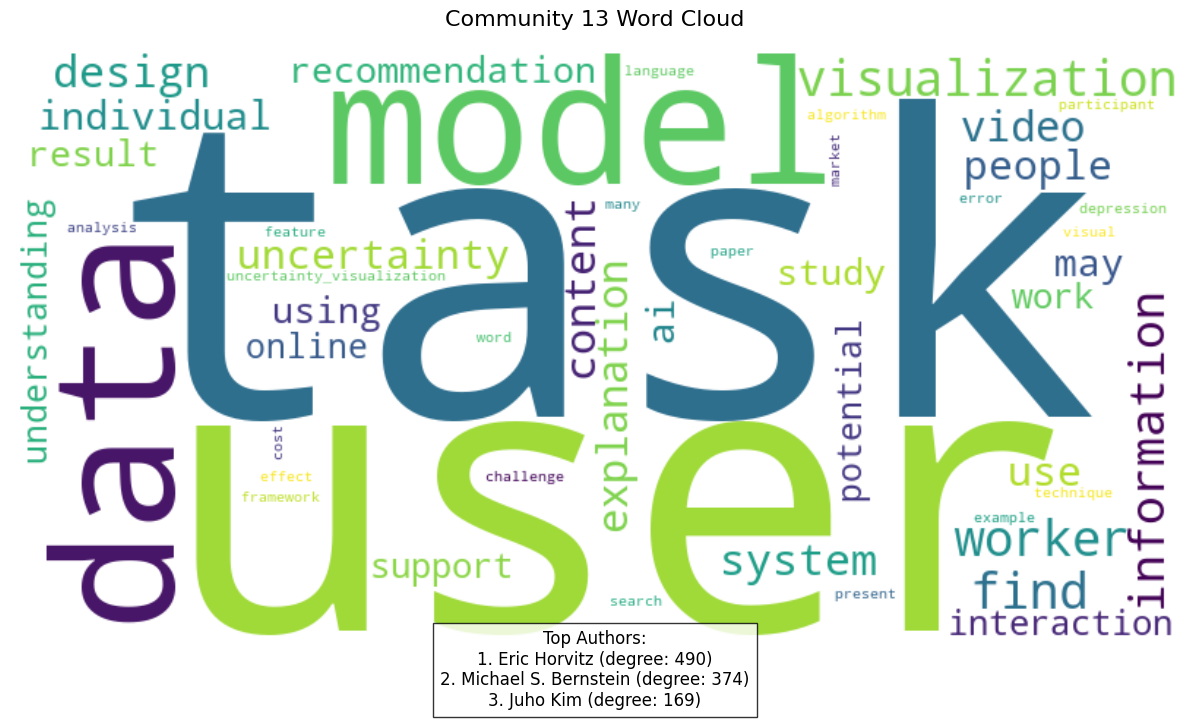

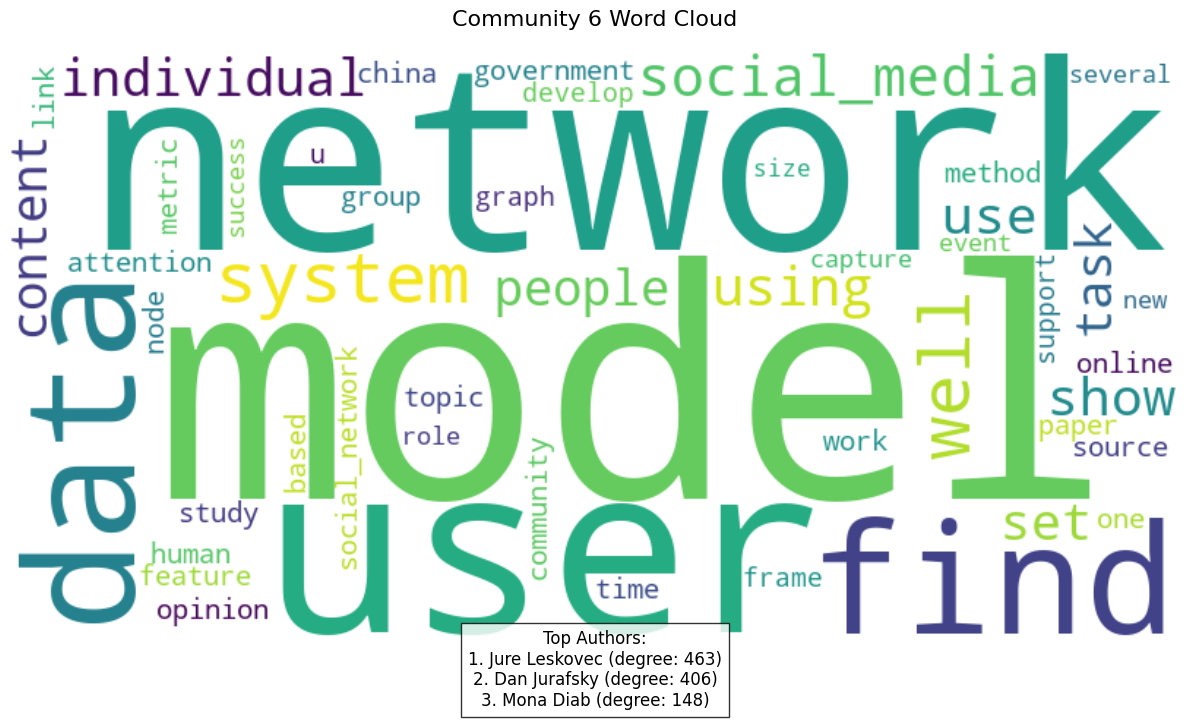

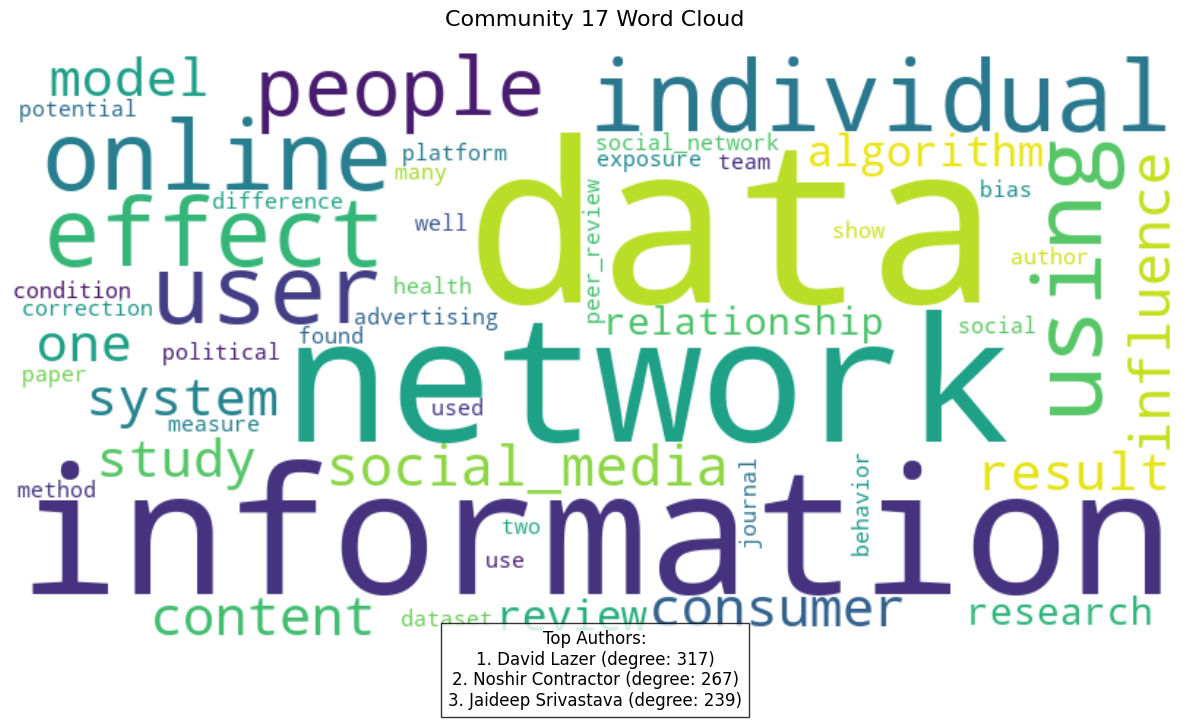

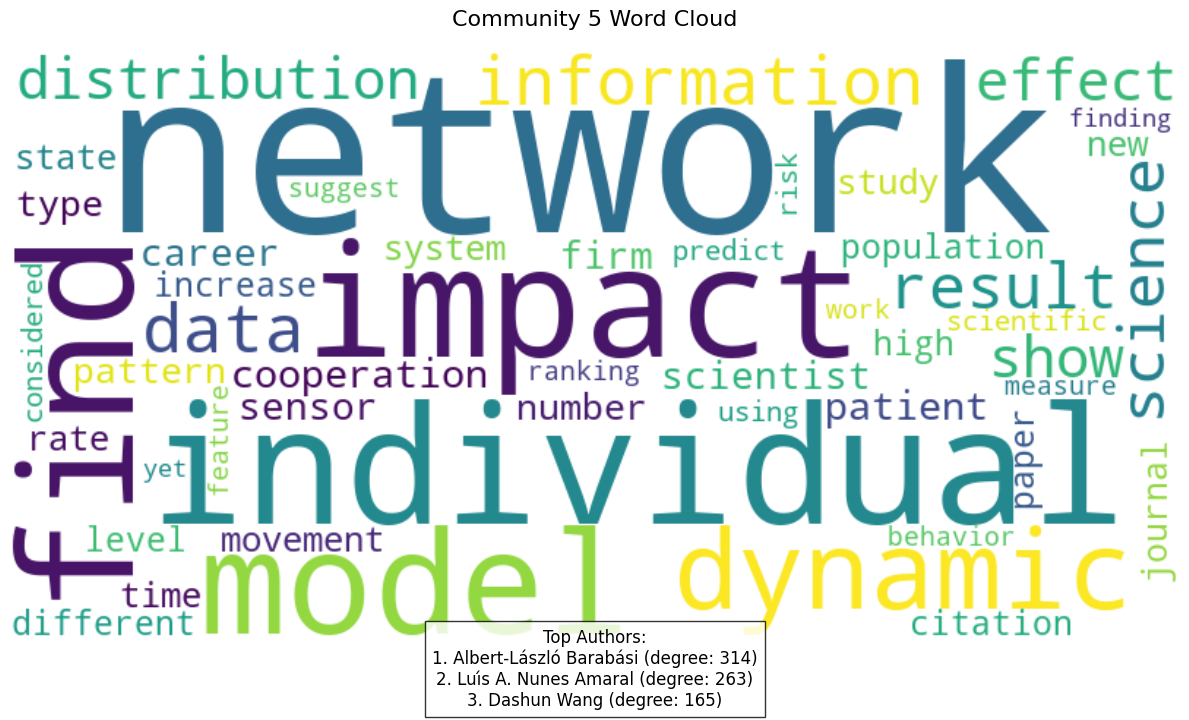

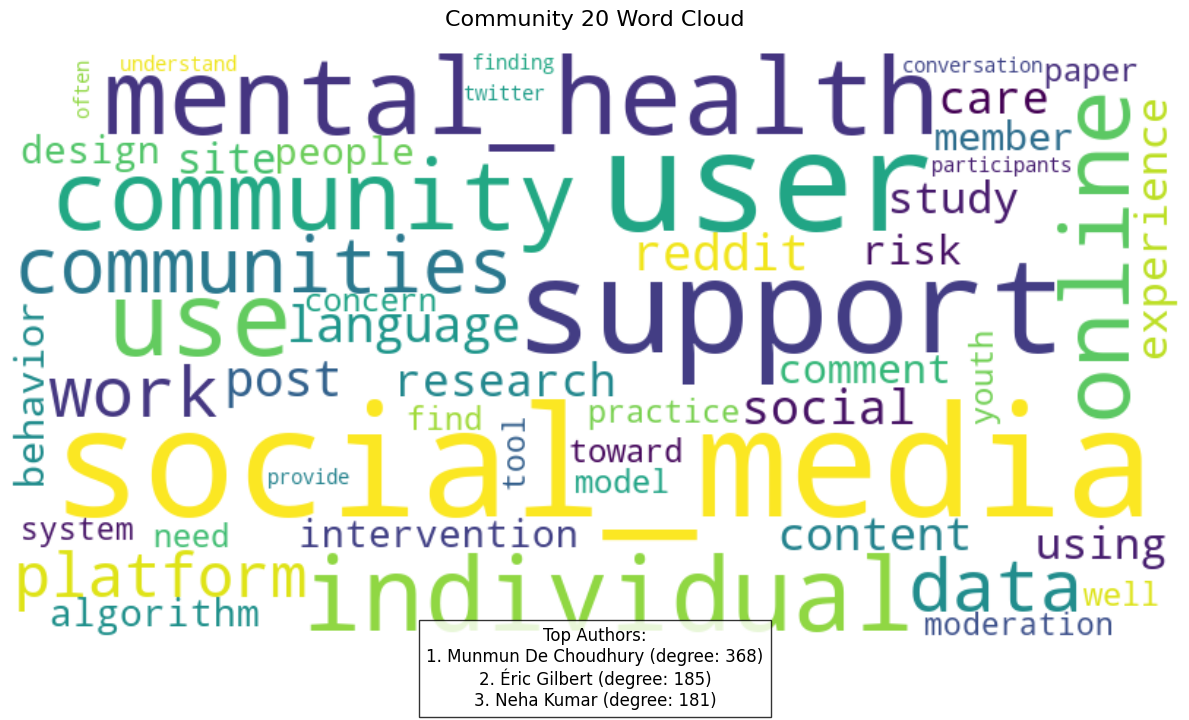

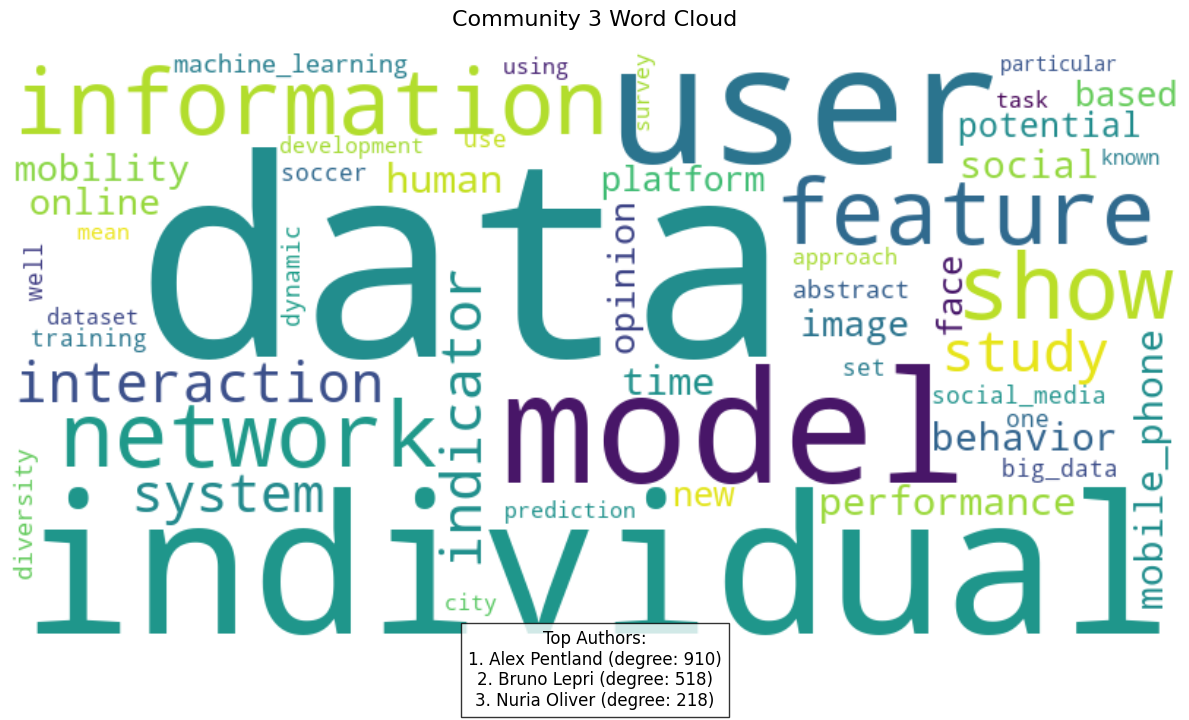

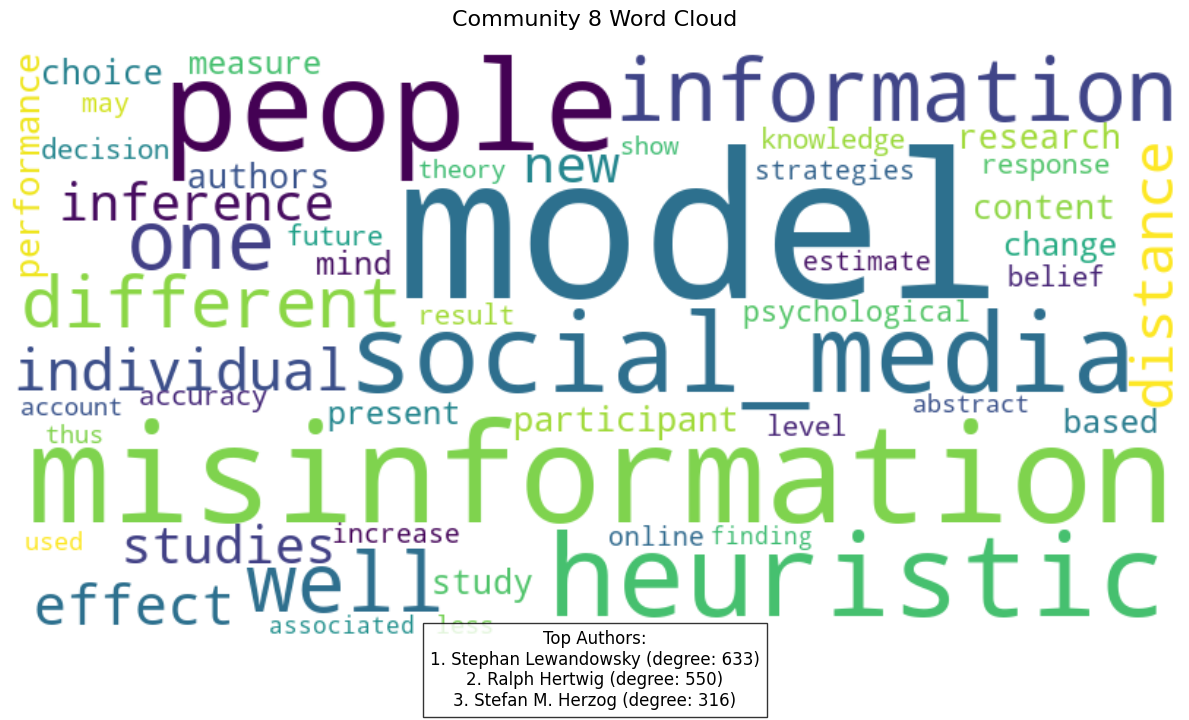

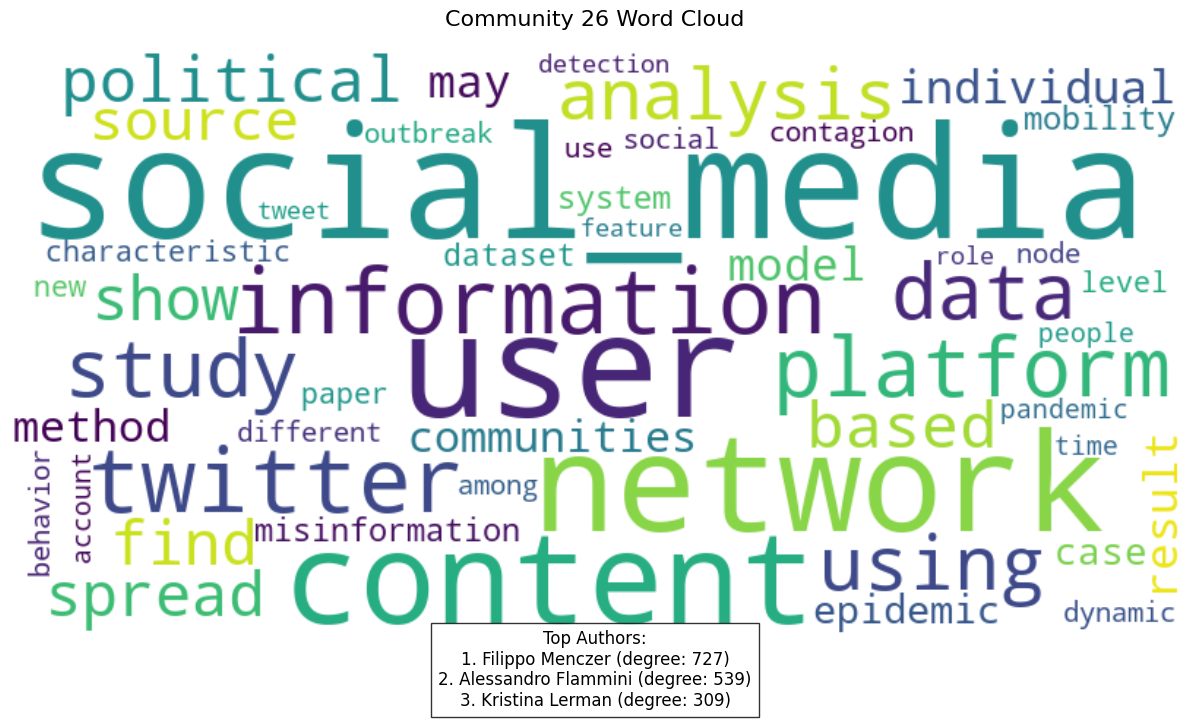

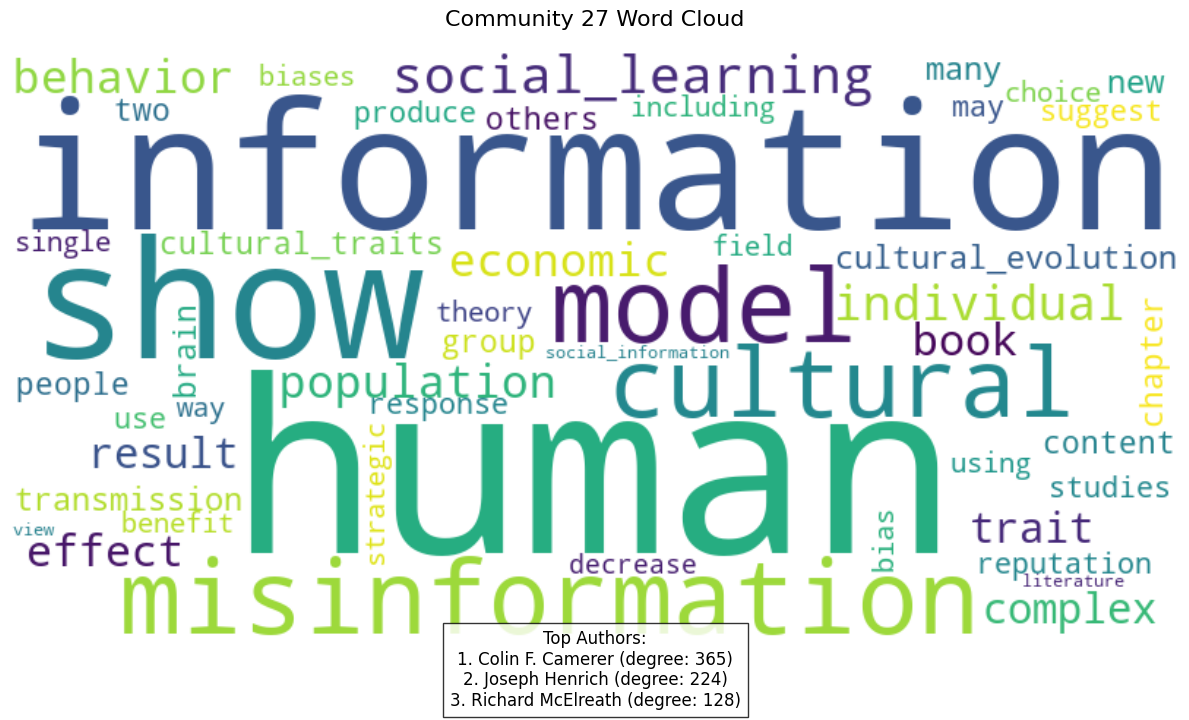

In [10]:
author_comm = pd.read_csv('author_communities.csv')
with open('community_token_arrays.json') as f:
    community_token_arrays = json.load(f)

top_communities = author_comm['community'].value_counts().head(9).index.astype(str).tolist()
top_authors = {}
for comm in top_communities:
    top_authors[comm] = (author_comm[author_comm['community'] == int(comm)]
                        .sort_values('degree', ascending=False)
                        .head(3)[['author_name', 'degree', 'author_id']]
                        .values.tolist())

for comm in top_communities:
    text = " ".join(community_token_arrays.get(comm, []))
    
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=50,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text)
    
    authors_info = "\n".join([
        f"{i+1}. {name if pd.notna(name) else f'[{author_id}]'} (degree: {degree})"
        for i, (name, degree, author_id) in enumerate(top_authors[comm])
    ])
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Community {comm} Word Cloud", fontsize=16, pad=20)
    plt.figtext(
        0.5, 0.05, 
        f"Top Authors:\n{authors_info}",
        ha="center",
        fontsize=12,
        bbox={"facecolor":"white", "alpha":0.8, "pad":5}
    )
    
    plt.tight_layout()
    plt.show()

## Comment on your results. What can you conclude on the different sub-communities in Computational Social Science?
### Answer: The different sub-communities may all have different focuses but they are all related to people in some way, with the presence of words like "human", "user", "individual" and "people".

## Look up online the top author in each community. In light of your search, do your results make sense?
### Yes, each of the top author in the communities appear to be professors in well-established universities who are credible, which correlates to the higher degree in the community. Furthermore, the words in the wordcloud seems to agree with their field of study. For example, in community 8 wordcloud, the top author Stephan Lewandowsky is a psychologist and the words present in the wordcloud appears to be related - such as 'psychological', 'participant', 'research'.

## Go back to Week 1, Exercise 1. Revise what you wrote on the topics in Computational Social Science. In light of your data-driven analysis, has your understanding of the field changed? How? (max 150 words)
### My understanding has changed slightly. Based on the results I have gotten, I believe Computational Social Science is highly relevant to humans. It is also not a single field of specific study, but rather a tapestry of different niches. Although there are some overlap (TF), the IDF terms shows the different focuses of each community. I also learnt that it is a highly interdisciplinary field,  as shown by the different words of IDFS - 'advertising', 'social media', 'cultural' and 'superspreaders' to name a few.